## Fit over correlation functions of knwon synthetic examples

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import sstats.tseries as ts

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50745 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### Exponential correlation :
$R_{xx} = R_{aa}(\tau)e^{-\tau/T_L}$

In [3]:
def C_exp(t,Tb):
    return np.exp(-t/Tb)

In [4]:
DT = 500
nT = 20
Tl = 7
x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=100).rename('x')
x

<xarray.DataArray 'x' (tau: 20, draw: 100, time: 12000)>
dask.array<getitem, shape=(20, 100, 12000), dtype=float64, chunksize=(20, 50, 12000), chunktype=numpy.ndarray>
Coordinates:
  * tau      (tau) int64 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
Attributes:
    rms:      1

### With or without detrending:

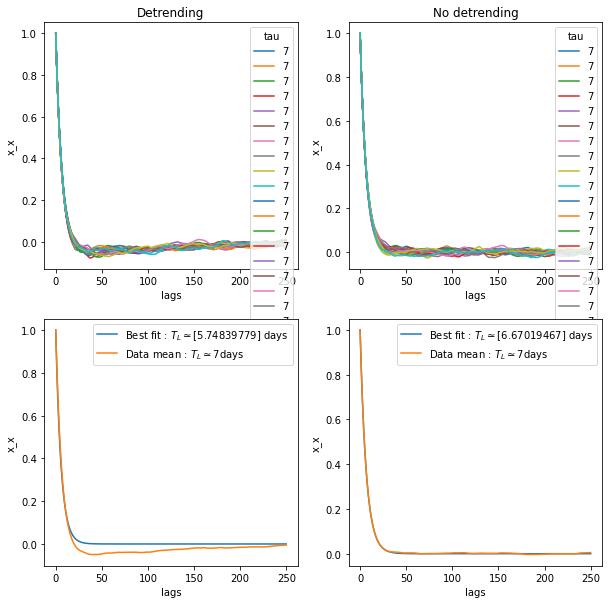

In [5]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for b,title,i in zip([True, False],['Detrending','No detrending'],range(2)):
    xx = ts.correlate(x,x,detrend=b).persist()
    _ = (xx/xx.sel(lags=0)).mean('draw').plot.line(ax=axes[0,i],x='lags')
    axes[0,i].set_title(title)
    pa,co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).mean(['draw','tau']))
    C_exp(xx.lags,*[p for p in pa]).plot(ax=axes[1,i],x='lags',label=r'Best fit : $T_L\simeq$%s days'%pa)
    (xx/xx.sel(lags=0)).mean(['draw','tau']).plot(ax=axes[1,i],label='Data mean : $T_L\simeq$7days')
    axes[1,i].legend()


#### Comments : 
First line : We see a negative lobe in the detrended case that is not observed in the second case. We can already expect a less acurate fit in the detrended case.\
Second line : As expected when simply looking at the mean (over all draws and windows) we find a value for $T_L$ closer to the true value, $T_L=7$days.\
Relative error for each case:\
With detrending : $\sim$ 18%\
Without detrending : $\sim$ 5%\
As it has been seen in our 'real' case, we expect this negative lobe to decrease when the total time window (DT) increases.Still it seems more accurate to use the non detrended time series.

### Fit mean over windows for each draw (no detrending) :

In [6]:
#xx = ts.correlate(x,x,detrend=False).persist()
pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
for i in range(xx.draw.size):
    pa[i],co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
    err[i] = np.abs(pa[i]-Tl)/Tl


Averaged over all draws and windows of the estimated $T_L$ : 6.689871736279916
Std of the estimated $T_L$ : 0.41899868579954935
Mean relative error : 6.031148611169079 percent


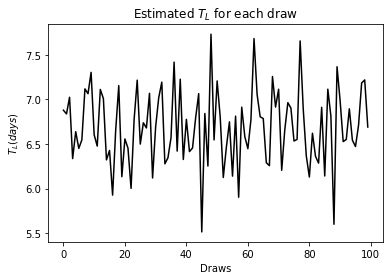

In [7]:
plt.plot(xx.draw,pa,'k');plt.title('Estimated $T_L$ for each draw')
plt.xlabel('Draws');plt.ylabel('$T_L (days)$')
print(r'Averaged over all draws and windows of the estimated $T_L$ : %s' %pa.mean())
print(r'Std of the estimated $T_L$ : %s' %pa.std())
print('Mean relative error : %s percent'% (err.mean()*1e2))

### Varying DT (time window size): 

In [9]:
def param_fit(x,DT,nT,Tl,n,detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl """
#    x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=n,detrend=detrend).rename('x')#.persist()
    xx = ts.correlate(x.sel(time=slice(0,DT)),x.sel(time=slice(0,DT))).persist()
    pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i],co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
        err[i] = np.abs(pa[i]-true_val)/true_val
    out = xr.Dataset({'params':(['draws'],pa),
                      'errors':(['draws'],err)},
                     coords={"draws":np.arange(0,n,1)})
    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [10]:
out = param_fit(x,100,20,7,100)

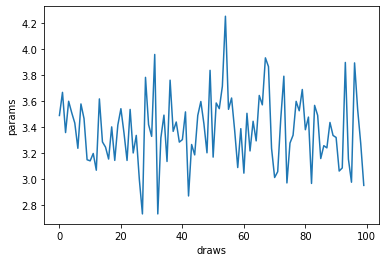

In [11]:
out.params.plot()

In [14]:
DT = [40,80,100,200]
out = xr.merge([param_fit(x,T,nT,Tl,100).rename({'params':'param_DT'+str(T),'errors':'err_DT'+str(T)}) for T in DT])

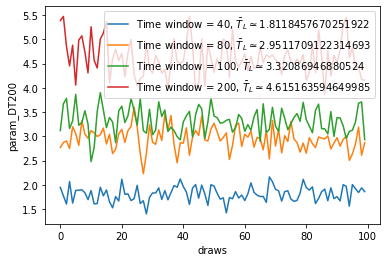

In [15]:
fig,ax = plt.subplots()
for T in ['40','80','100','200']:
    out['param_DT'+T].plot(ax=ax,label=r'Time window = %s, $\bar T_L\simeq$%s'% (T,out['param_DT'+T].mean().values))
    ax.legend()

#### Comments : 
As expected, the larger the window size is the better the estimation. For now we only use part of the time series (selection of first time steps only). We should change the function correlate to be closer of our 'real case'.

### Varying the nulber of draws and windows (n and nT) :
We choose to create a "big" dataset and then use a depreciated dataset to compute ou parameter.

In [19]:
DT = 500
nT = 50
n = 1000
Tl = 7
x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=1000).rename('x')
x

,Array,Chunk
Bytes,4.80 GB,60.00 MB
Shape,"(50, 1000, 12000)","(25, 25, 12000)"
Count,323 Tasks,80 Chunks
Type,float64,numpy.ndarray


In [32]:
def param_fit(x,DT,nT,Tl,n,detrend=False):
    """Generate n samples using ts.exp_autocorr 
    and find the best fit for each sample and the relative error to the true value Tl """
#    x = ts.exp_autocorr((DT, 1./24), np.full((nT,),Tl), 1, draws=n,detrend=detrend).rename('x')#.persist()
    xx = ts.correlate(x.sel(time=slice(0,DT)).isel(tau=slice(0,nT),draw=slice(0,n)),
                      x.sel(time=slice(0,DT)).isel(tau=slice(0,nT),draw=slice(0,n))).persist()
    pa,err = np.full((xx.draw.size),np.nan),np.full(xx.draw.size,np.nan)
    true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i],co = scipy.optimize.curve_fit(C_exp,xx.lags,(xx/xx.sel(lags=0)).isel(draw=i).mean(['tau']))
        err[i] = np.abs(pa[i]-true_val)/true_val
    
    out = xr.Dataset({'params':(['draws'],pa),
                      'errors':(['draws'],err)},
                     coords={"draws":np.arange(0,n,1)})
    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [35]:
nT = [2,5,10,30]
DT = 500
n = 100
out = xr.merge([param_fit(x,DT,nt,Tl,n).rename({'params':'param_nT'+str(nt),'errors':'err_nT'+str(nt)}) for nt in nT])

1.3027333758631199
0.64638631586241
0.4740043709662466
0.2821226918316192


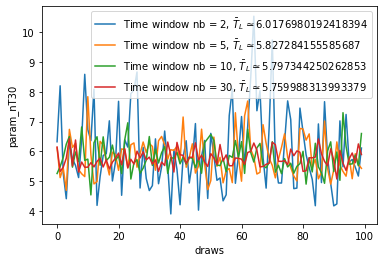

In [41]:
fig,ax = plt.subplots()
for T in ['2','5','10','30']:
    out['param_nT'+T].plot(ax=ax,label=r'Time window nb = %s, $\bar T_L\simeq$%s'% (T,out['param_nT'+T].mean().values))
    ax.legend()
    print(out['param_nT'+T].std().values)

### Comments : 
Mean value remains around 5.8 days (slight decrease when nT increases). However the std decreases.

In [42]:
nT = 20
DT = 500
n = [50,100,500,1000]
out = xr.merge([param_fit(x,DT,nT,Tl,N).rename({'params':'param_n'+str(N),'errors':'err_n'+str(N)}) for N in n])

0.41502900359572864
0.33506906710522566
0.3216202550459166
0.3349430530508093


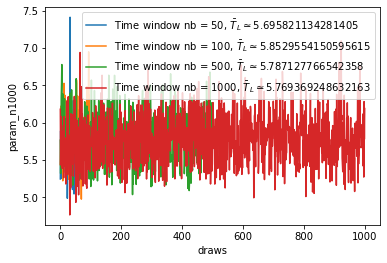

In [44]:
fig,ax = plt.subplots()
for T in ['50','100','500','1000']:
    out['param_n'+T].plot(ax=ax,label=r'Time window nb = %s, $\bar T_L\simeq$%s'% (T,out['param_n'+T].mean().values))
    ax.legend()
    print(out['param_n'+T].std().values)

In [45]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
